In [71]:
import sys
sys.path.append('../')
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import matplotlib as mpl
import numpy as np

from utils import db

conn = db.connect()
pd.set_option('display.max_rows', 100)
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# pd.read_sql("""SELECT * FROM stakes""", conn)

## Key analysis categories:
- Top 25 accounts: days staked & amount over time
- Demographics of long duration stakers vs. short duration
- Demographics of committed stakers vs. early withdrawers
- Demographics of high frequency stakers
- When did stakers unstake?
- long time staked, large quantity staked, high frequency new stakes, low early unstaking
- Uniswap liquidity stability

# Flash V2 History
On March 6, 2021, the FLASH/ETH pair pool was created on Uniswap.

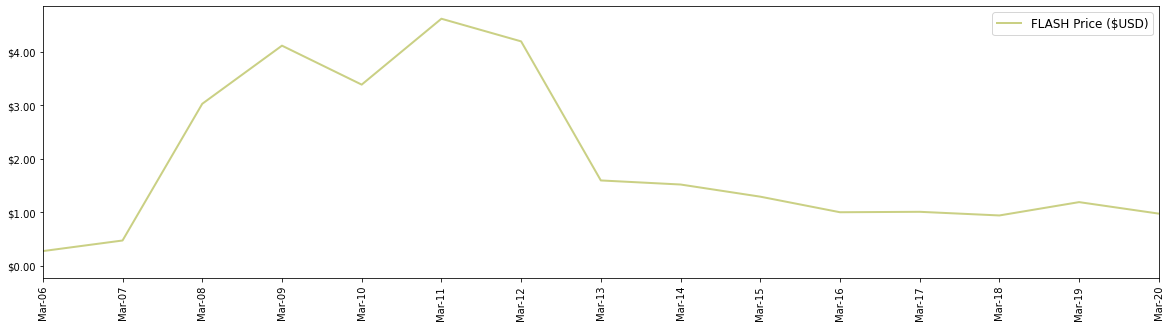

In [18]:
hist = pd.read_sql("""SELECT *
FROM uniswap uni
ORDER BY uni.date;""",conn)

fig, ax1 = plt.subplots(figsize=(20, 5))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

# Plot the Uniswap FLASH/USD price
ax1.plot(hist["date"], hist["price"], color='#CAD084', linewidth=2, label="FLASH Price ($USD)", zorder=0)
ax1.zorder = 1
ax1.patch.set_alpha(0)
# ax1.set_ylim([0, 1.5])
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.2f}'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.legend(bbox_to_anchor = (1, 1), prop={'size':12})
ax1.set_xlim([datetime.date(2021,3,6), datetime.date(2021,3,20)])
plt.show()

### Initial Price Spike
Due to low liquidity and immediate buying of FLASH, the price quickly piked to over \\$4.50 before settling down to around $1.00 as more liquidity was added, stabilizing the price.

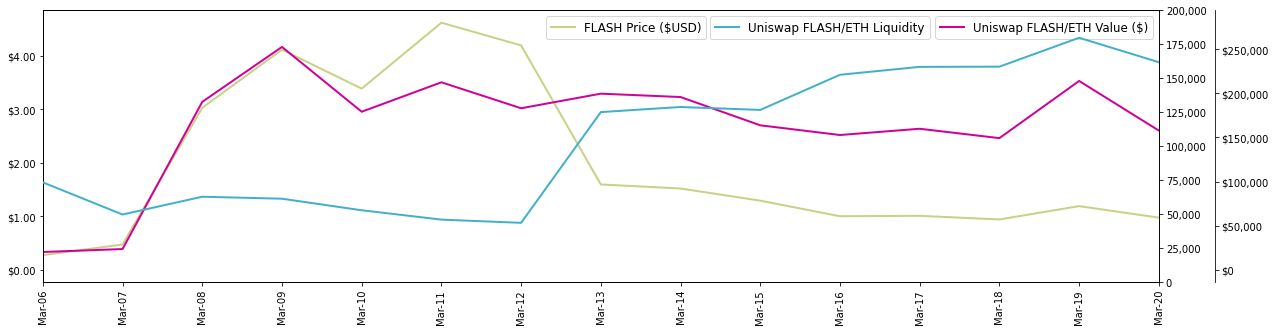

In [40]:
hist = pd.read_sql("""SELECT *
FROM uniswap uni
LEFT JOIN
    (
        SELECT stakedatetime, COUNT(fromaddress) AS stakecount, SUM(amountin) staketotal
        FROM stakes
        GROUP BY stakedatetime
        ORDER BY stakedatetime DESC
    ) AS s1
ON s1.stakedatetime=uni.date
ORDER BY uni.date;""",conn)

fig, ax1 = plt.subplots(figsize=(20, 5))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

# Plot the Uniswap FLASH/USD price
ax1.plot(hist["date"], hist["price"], color='#CAD084', linewidth=2, label="FLASH Price ($USD)", zorder=0)
ax1.zorder = 1
ax1.patch.set_alpha(0)
# ax1.set_ylim([0, 1.5])
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.2f}'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.legend(bbox_to_anchor = (.6, 1), prop={'size':12})
ax1.set_xlim([datetime.date(2021,3,6), datetime.date(2021,3,20)])

# Plot the Uniswap FLASH/ETH pool historical liquidity value
ax3 = ax1.twinx()
ax3.plot(hist["date"], hist["value"], color='#D10097', linewidth=2, label="Uniswap FLASH/ETH Value ($)", zorder=10)
ax3.zorder = 2
ax3.patch.set_alpha(0)
ax3.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax3.legend(bbox_to_anchor = (1, 1), prop={'size':11.75})

ax3.spines['right'].set_position(("axes", 1.05))
ax3.spines['right'].set_visible(True)
ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')

# Plot the Uniswap FLASH/ETH pool historical liquidity quantity
ax4 = ax1.twinx()
ax4.plot(hist["date"], hist["liquidity"], color='#43B0CA', linewidth=2, label="Uniswap FLASH/ETH Liquidity", zorder=5)
ax4.zorder = 3
ax4.patch.set_alpha(0)
ax4.set_ylim([0, 200000])
ax4.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# ax4.legend("Liquidity", bbox_to_anchor = (1.05, 0.6))
ax4.legend(bbox_to_anchor = (.8, 1), prop={'size':12})
plt.show()

### Flash Staking
On the same day that a lot of liquidity was dumped into the Uniswap FLASH/ETH pool, nearly 80 stakes were executed with over 2 million $FLASH staked.

In [72]:
mar13 = pd.read_sql("""SELECT uni.date, TO_CHAR(uni.liquidity, '999,999,999') AS "Liquidity", s1.stakecount AS "Stake Count", TO_CHAR(s1.staketotal, '999,999,999') AS "Total Tokens Staked"
FROM uniswap uni
LEFT JOIN
    (
        SELECT stakedatetime, COUNT(fromaddress) AS stakecount, SUM(amountin) staketotal
        FROM stakes
        GROUP BY stakedatetime
        ORDER BY stakedatetime DESC
    ) AS s1
ON s1.stakedatetime=uni.date
WHERE uni.date='2021-03-13'::date;""",conn)
display(mar13)

,date,Liquidity,Stake Count,Total Tokens Staked
0,2021-03-13,"125,151",77,"2,045,963"


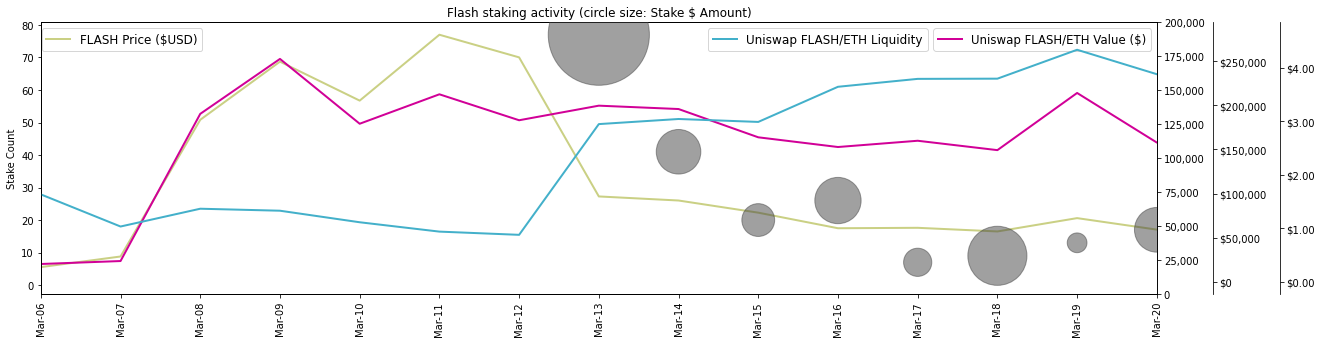

In [47]:
hist = pd.read_sql("""SELECT *
FROM uniswap uni
LEFT JOIN
    (
        SELECT stakedatetime, COUNT(fromaddress) AS stakecount, SUM(amountin) staketotal
        FROM stakes
        GROUP BY stakedatetime
        ORDER BY stakedatetime DESC
    ) AS s1
ON s1.stakedatetime=uni.date
ORDER BY uni.date;""",conn)

fig, ax1 = plt.subplots(figsize=(20, 5))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)
plt.title("Flash staking activity (circle size: Stake $ Amount)")

# Plot the stake data
# ax1.scatter(hist["date"], hist["stakecount"], s=hist["staketotal"] / 200, color='#cad084', alpha=0.7)
ax1.scatter(hist["date"], hist["stakecount"], s=hist["staketotal"] / 200, color='#424242', alpha=0.5, zorder=50) #, label="Number of Stakes")
ax1.zorder = 5
ax1.patch.set_alpha(0)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.set_ylabel('Stake Count')
ax1.set_xlim([datetime.date(2021,3,6), datetime.date(2021,3,20)])

# Plot the Uniswap FLASH/USD price
ax2 = ax1.twinx()
ax2.plot(hist["date"], hist["price"], color='#CAD084', linewidth=2, label="FLASH Price ($USD)", zorder=0)
ax2.zorder = 1
ax2.patch.set_alpha(0)
# ax2.set_ylim([0, 1.5])
ax2.yaxis.set_major_formatter(StrMethodFormatter('${x:,.2f}'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax2.legend(bbox_to_anchor = (.15, 1), prop={'size':12})
ax2.set_xlim([datetime.date(2021,3,6), datetime.date(2021,3,20)])

ax2.spines['right'].set_position(("axes", 1.11))
ax2.spines['right'].set_visible(True)
ax2.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('right')

# Plot the Uniswap FLASH/ETH pool historical liquidity value
ax3 = ax1.twinx()
ax3.plot(hist["date"], hist["value"], color='#D10097', linewidth=2, label="Uniswap FLASH/ETH Value ($)", zorder=10)
ax3.zorder = 2
ax3.patch.set_alpha(0)
ax3.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax3.legend(bbox_to_anchor = (1, 1), prop={'size':11.75})

ax3.spines['right'].set_position(("axes", 1.05))
ax3.spines['right'].set_visible(True)
ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')

# Plot the Uniswap FLASH/ETH pool historical liquidity quantity
ax4 = ax1.twinx()
ax4.plot(hist["date"], hist["liquidity"], color='#43B0CA', linewidth=2, label="Uniswap FLASH/ETH Liquidity", zorder=5)
ax4.zorder = 3
ax4.patch.set_alpha(0)
ax4.set_ylim([0, 200000])
ax4.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# ax4.legend("Liquidity", bbox_to_anchor = (1.05, 0.6))
ax4.legend(bbox_to_anchor = (.8, 1), prop={'size':12})
plt.show()